# PCAM Dataset Classification

In [2]:
### Importing all the necessary libraries for the project
#General
import os
import warnings

# Utilis 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

#Data Manipulation
import h5py
import hashlib
import numpy as np
import pandas as pd

# ML
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import xgboost as xgb

# CNN
import torch
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from tqdm import tqdm
from skorch import NeuralNetBinaryClassifier


### I have ran trained the model on Apple Silicon and used *pytorch-nightly* version of pytorch for GPU accelration.  
The code should run with other hardware components like CPU or a general GPU as well

In [95]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


Ignoring warnings that might arise

In [96]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# Data Preparation

The following functions create a hash the images using a hashing algorithm and remove the duplicates from X and Y datasets.  
1. *compute_hash(image)* uses MD5 algorithm (Message Digest Algorithm 5) to return a hash object of the image.  
2. *remove_duplicates(X, Y)* calls *compute_hash* to get the hash objects and then compares these objects to remove duplicates

In [97]:
# Function to compute a hash for an image
def compute_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Remove duplicate images from a dataset
def remove_duplicates(X, Y):
    unique_images = {}
    indices_to_keep = []

    for i, image in enumerate(X):
        image_hash = compute_hash(image)
        
        # Check if the object is present in the dictionary
        if image_hash not in unique_images:
            unique_images[image_hash] = i
            indices_to_keep.append(i)  # Keep this image's index
            
    # Filtering out duplicates
    X_unique = X[indices_to_keep]
    Y_unique = Y[indices_to_keep]
    
    return X_unique, Y_unique

Importing the images from the local machine. You may have to change the path to run the cell.  
WARNING: May take a lot of time depending on the hardware.

In [98]:
train_x_h5 = 'PCAM_Data/camelyonpatch_level_2_split_train_x.h5'
train_y_h5 = 'PCAM_Data/camelyonpatch_level_2_split_train_y.h5'
val_x_h5 = 'PCAM_Data/camelyonpatch_level_2_split_valid_x.h5'
val_y_h5 = 'PCAM_Data/camelyonpatch_level_2_split_valid_y.h5'
test_x_h5 = 'PCAM_Data/camelyonpatch_level_2_split_test_x.h5'
test_y_h5 = 'PCAM_Data/camelyonpatch_level_2_split_test_y.h5'

with h5py.File(train_x_h5, 'r') as x_train_f, h5py.File(train_y_h5, 'r') as y_train_f, h5py.File(val_x_h5, 'r') as x_val_f, h5py.File(val_y_h5, 'r') as y_val_f,h5py.File(test_x_h5, 'r') as x_test_f, h5py.File(test_y_h5, 'r') as y_test_f:
    X_train = x_train_f['x'][:]
    Y_train = y_train_f['y'][:]
    X_val = x_val_f['x'][:]
    Y_val = y_val_f['y'][:]
    X_test = x_test_f['x'][:]
    Y_test = y_test_f['y'][:]

In [99]:
#Printing the shapes of the data
print('{Dataset}: {Shape}')
print('x train shapes:', X_train.shape)
print('y train shapes:', Y_train.shape)
print('x validation shapes:', X_val.shape)
print('y validation shapes:', Y_val.shape)
print('x test shapes:', X_test.shape)
print('y test shapes:', Y_test.shape)

{Dataset}: {Shape}
x train shapes: (262144, 96, 96, 3)
y train shapes: (262144, 1, 1, 1)
x validation shapes: (32768, 96, 96, 3)
y validation shapes: (32768, 1, 1, 1)
x test shapes: (32768, 96, 96, 3)
y test shapes: (32768, 1, 1, 1)


In [100]:
total_images = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
print("Total number of images before removing duplicates: ", total_images)

Total number of images before removing duplicates:  327680


Removing Duplicates using the above functions.  
WARNING: May take some time.

In [101]:
X_train, Y_train = remove_duplicates(X_train, Y_train)
X_val, Y_val = remove_duplicates(X_val, Y_val)
X_test, Y_test = remove_duplicates(X_test, Y_test)
print('x train shapes:', X_train.shape)
print('y train shapes:', Y_train.shape)
print('x validation shapes:', X_val.shape)
print('y validation shapes:', Y_val.shape)
print('x test shapes:', X_test.shape)
print('y test shapes:', Y_test.shape)

x train shapes: (220025, 96, 96, 3)
y train shapes: (220025, 1, 1, 1)
x validation shapes: (28108, 96, 96, 3)
y validation shapes: (28108, 1, 1, 1)
x test shapes: (29383, 96, 96, 3)
y test shapes: (29383, 1, 1, 1)


In [102]:
total_images = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
print("Total number of images after removing duplicates: ", total_images)

Total number of images after removing duplicates:  277516


Flattening the labels into a single vector

In [103]:
Y_train = pd.DataFrame({'Label': Y_train.flatten()})
Y_val = pd.DataFrame({'Label': Y_val.flatten()})
Y_test = pd.DataFrame({'Label': Y_test.flatten()})

In [104]:
print("Train: ", Y_train.value_counts(), "\n")
print("Validation: ", Y_val.value_counts(), "\n")
print("Test: ", Y_test.value_counts(), "\n")

Train:  Label
0        130908
1         89117
Name: count, dtype: int64 

Validation:  Label
0        16386
1        11722
Name: count, dtype: int64 

Test:  Label
0        16389
1        12994
Name: count, dtype: int64 



### Data Imbalance  
After removing duplicates the data showed data imbalance with a majority of images that were classified as non-malignant.  
The following cell removes a few random samples from the majority class to balance the classes.(Downsampling)

In [105]:
Y_train_flat = Y_train.values.reshape(-1)
Y_val_flat = Y_val.values.reshape(-1)
Y_test_flat = Y_test.values.reshape(-1)

# Get minority class counts for each set
min_class_count_train = min((Y_train_flat == 0).sum(), (Y_train_flat == 1).sum())
min_class_count_val = min((Y_val_flat == 0).sum(), (Y_val_flat == 1).sum())
min_class_count_test = min((Y_test_flat == 0).sum(), (Y_test_flat == 1).sum())

# Function to balance a dataset by downsampling the majority class
def balance_classes(X, Y, min_class_count):
    class_0_indices = np.where(Y == 0)[0]
    class_1_indices = np.where(Y == 1)[0]
    
    balanced_class_0_indices = np.random.choice(class_0_indices, min_class_count, replace=False)
    balanced_class_1_indices = np.random.choice(class_1_indices, min_class_count, replace=False)
    balanced_indices = np.concatenate([balanced_class_0_indices, balanced_class_1_indices])
    np.random.shuffle(balanced_indices)
    X_balanced = X[balanced_indices]
    Y_balanced = Y[balanced_indices].reshape(-1, 1)
    
    return X_balanced, Y_balanced

# Balance each set
X_train_balanced, Y_train_balanced = balance_classes(X_train, Y_train_flat, min_class_count_train)
X_val_balanced, Y_val_balanced = balance_classes(X_val, Y_val_flat, min_class_count_val)
X_test_balanced, Y_test_balanced = balance_classes(X_test, Y_test_flat, min_class_count_test)

# Convert to pandas DataFrames
Y_train_df = pd.DataFrame(Y_train_balanced)
Y_val_df = pd.DataFrame(Y_val_balanced)
Y_test_df = pd.DataFrame(Y_test_balanced)

# Print final shapes for verification
print("Balanced X_train shape:", X_train_balanced.shape)  
print("Balanced Y_train shape:", Y_train_balanced.shape)
print("Balanced X_val shape:", X_val_balanced.shape)
print("Balanced Y_val shape:", Y_val_balanced.shape)
print("Balanced X_test shape:", X_test_balanced.shape)
print("Balanced Y_test shape:", Y_test_balanced.shape)


Balanced X_train shape: (178234, 96, 96, 3)
Balanced Y_train shape: (178234, 1)
Balanced X_val shape: (23444, 96, 96, 3)
Balanced Y_val shape: (23444, 1)
Balanced X_test shape: (25988, 96, 96, 3)
Balanced Y_test shape: (25988, 1)


In [106]:
print("Train: ", Y_train_df.value_counts(), "\n")
print("Validation: ", Y_val_df.value_counts(), "\n")
print("Test: ", Y_test_df.value_counts(), "\n")

Train:  0
0    89117
1    89117
Name: count, dtype: int64 

Validation:  0
0    11722
1    11722
Name: count, dtype: int64 

Test:  0
0    12994
1    12994
Name: count, dtype: int64 



In [107]:
X_train = X_train_balanced
Y_train = Y_train_df
X_val = X_val_balanced
Y_val = Y_val_df
X_test = X_test_balanced
Y_test = Y_test_df

### Data splitting
1. Although the dataset is given after splitting up the images we will sample the dataset further and use 50000 as the total number of images.  
2. We will then split these images in the ratio of 8:1:1 for training, validation and test datasets

In [108]:
total_images=50000
train_size = int(total_images * 0.8)
val_size = int(total_images * 0.1)
test_size = int(total_images * 0.1)

print("Train size: ", train_size, "\nValidation size: ", val_size, "\nTest size: ", test_size)

Train size:  40000 
Validation size:  5000 
Test size:  5000


In [109]:
#Splitting the datasets
x_train, _, y_train, _ = train_test_split(X_train, Y_train, train_size= train_size, stratify=Y_train, random_state=42)
x_val, _, y_val, _ = train_test_split(X_val, Y_val, train_size= val_size, stratify=Y_val, random_state=42)
x_test, _, y_test, _ = train_test_split(X_test, Y_test, train_size= test_size, stratify=Y_test, random_state=42)

# Print the target variables for checking if the balance is mantained
print(f"\nTarget variable balance - TRAIN: {y_train.value_counts()}")
print(f"\nTarget variable balance - VAL: {y_val.value_counts()}")
print(f"\nTarget variable balance - TEST: {y_test.value_counts()}")


Target variable balance - TRAIN: 0
0    20000
1    20000
Name: count, dtype: int64

Target variable balance - VAL: 0
0    2500
1    2500
Name: count, dtype: int64

Target variable balance - TEST: 0
0    2500
1    2500
Name: count, dtype: int64


### WARNING: DO NOT RUN the below cell.

In [110]:
# Saving the data
# y_train.to_pickle('Data/y_train.pkl')
# y_val.to_pickle('Data/y_val.pkl')
# y_test.to_pickle('Data/y_test.pkl')
# np.save('Data/x_train.npy', x_train)
# np.save('Data/x_val.npy', x_val)
# np.save('Data/x_test.npy', x_test)

# Exploratory Data Analysis  
Here we are loading the saved data which is already cleaned and split by the above code for easy access and reading

In [3]:
x_train = np.load('Data/x_train.npy')
x_val = np.load('Data/x_val.npy')
x_test = np.load('Data/x_test.npy')
y_train = pd.read_pickle('Data/y_train.pkl')
y_val = pd.read_pickle('Data/y_val.pkl')
y_test = pd.read_pickle('Data/y_test.pkl')

### Visualization  
We will now visualize the images 

In [3]:
# Function for plotting
def plot_images_with_labels(x_data, y_data, malignant_indx, non_malignant_indx):
    nrows = 2
    ncols = 5
    # Creating subplots
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 8))
    fig.suptitle('Histopathologic scans', fontsize=20)

    for row in range(nrows):
        for col in range(ncols):
            if row == 0:
                index = non_malignant_indx[col]
            else:  
                index = malignant_indx[col]

            # Retrieve the corresponding image and label
            image = x_data[index]
            label = y_data.iloc[index, 0]

            # Plot the image 
            ax[row, col].imshow(image)
            # with a bounding box based on the label
            box_color = 'r' if label == 1 else 'b'
            box = patches.Rectangle((1, 1), 94, 94, linewidth=4, edgecolor=box_color,
                                    facecolor='none', linestyle=':', capstyle='round')
            ax[row, col].add_patch(box)
            ax[row, col].set_title(f'Label: {label}', color='white')

    # Add a legend
    legend_elements = [patches.Patch(facecolor='none', edgecolor='r', linewidth=2, label='Malignant (Tumor)'),
                       patches.Patch(facecolor='none', edgecolor='b', linewidth=2, label='Non-Malignant (No Tumor)')]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0.5, fontsize='large')

    plt.show()

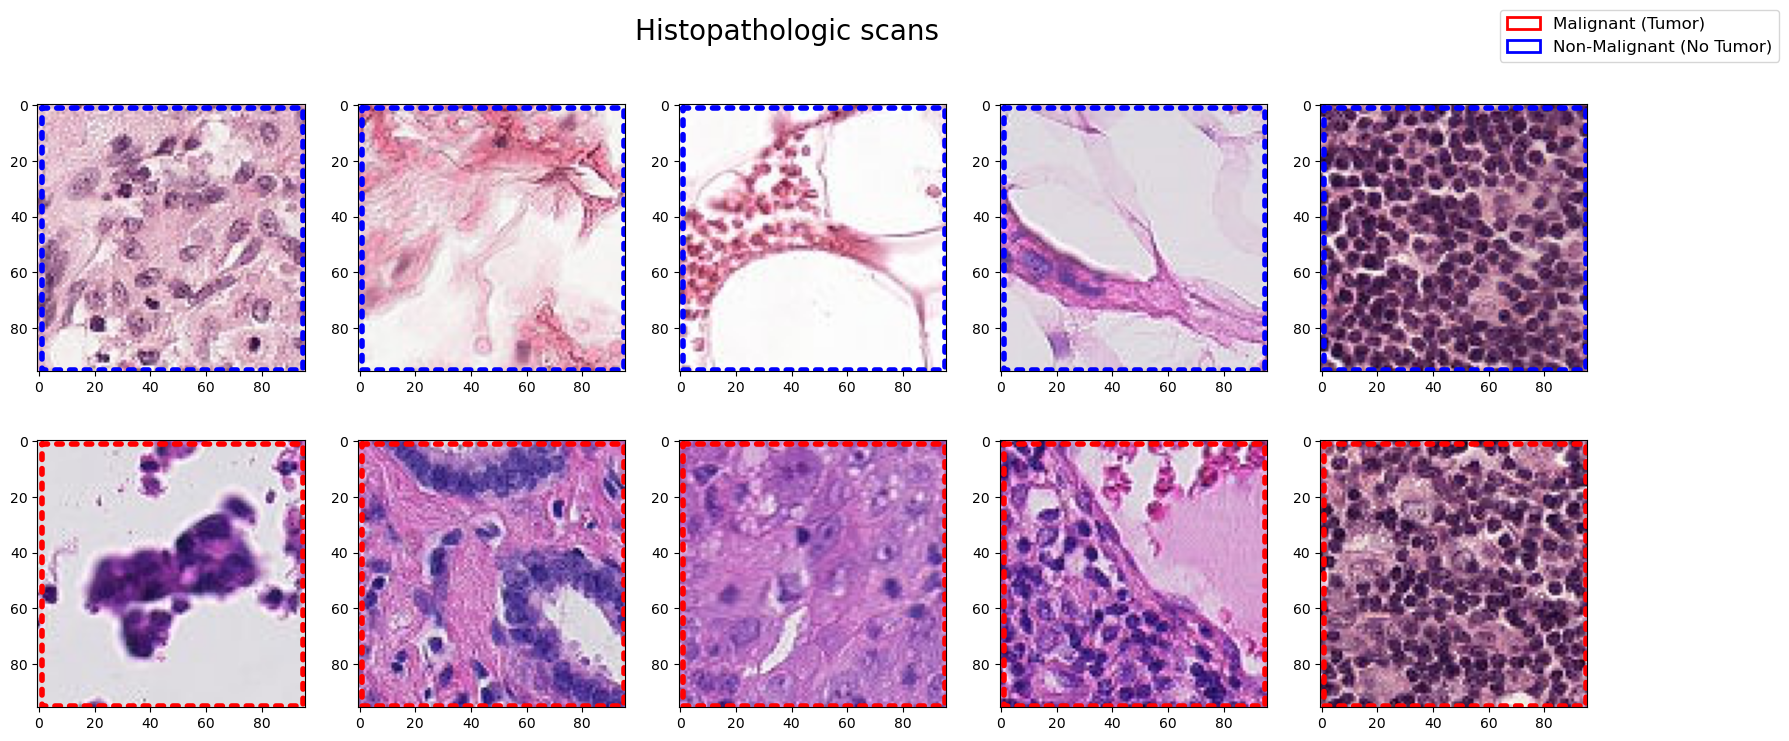

In [4]:
# All indices
malignant_indices = np.where(y_train == 1)[0]
non_malignant_indices = np.where(y_train == 0)[0]

# Randomly sample 5 malignant and 5 non-malignant indices
rnd_malignant_indx = np.random.choice(malignant_indices, size=5, replace=False)
rnd_non_malignant_indx = np.random.choice(non_malignant_indices, size=5, replace=False)

# Plot
plot_images_with_labels(x_train, y_train, rnd_malignant_indx, rnd_non_malignant_indx)

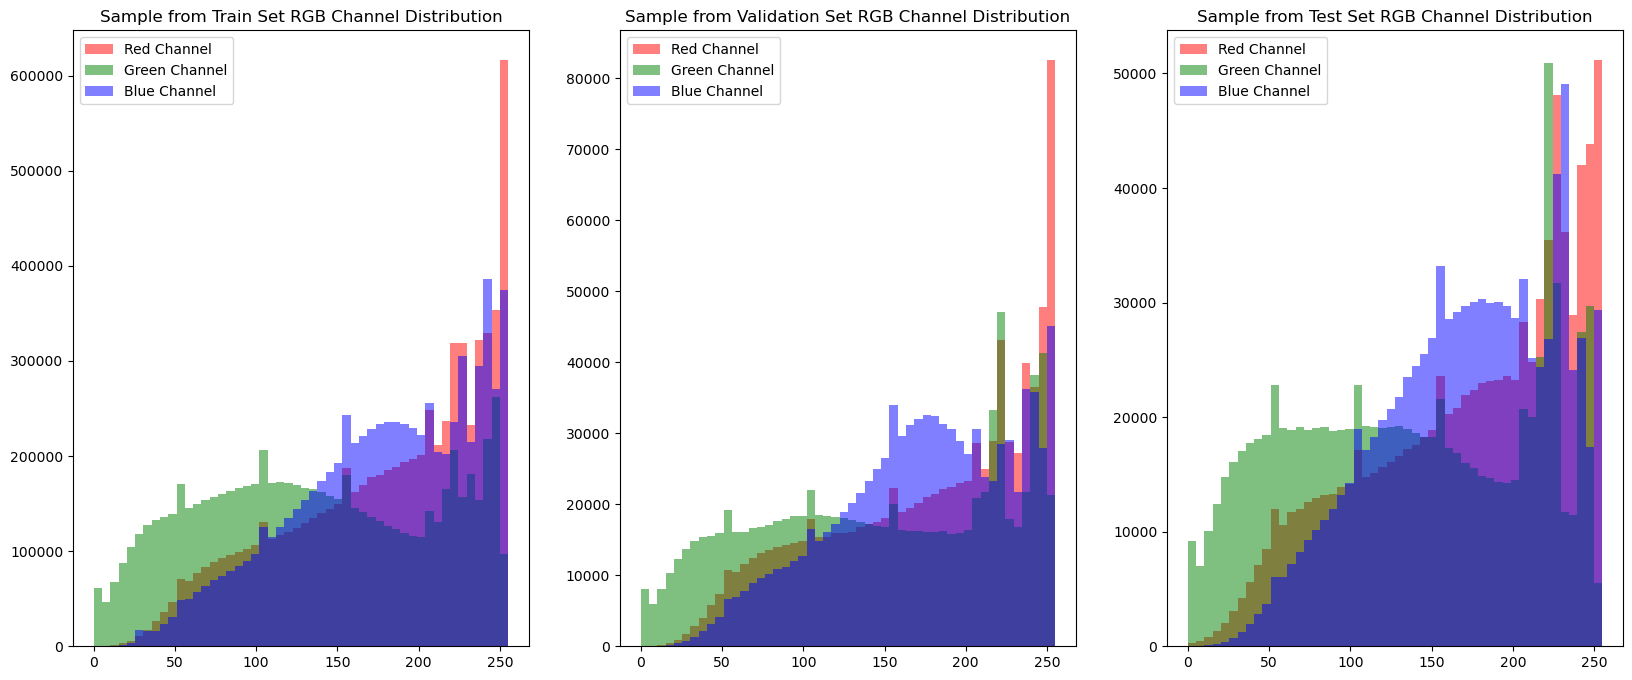

In [4]:
# Plot RGB Channel Distribution
np.random.seed(42)

r_train_values = x_train[:,:,:,0]
g_train_values = x_train[:,:,:,1]
b_train_values = x_train[:,:,:,2]

r_train_indices = np.random.choice(r_train_values.shape[0], 800, replace=False)
g_train_indices = np.random.choice(g_train_values.shape[0], 800, replace=False)
b_train_indices = np.random.choice(b_train_values.shape[0], 800, replace=False)
r_train_values = r_train_values[r_train_indices].flatten()
g_train_values = g_train_values[g_train_indices].flatten()
b_train_values = b_train_values[b_train_indices].flatten()


r_val_values = x_val[:,:,:,0]
g_val_values = x_val[:,:,:,1]
b_val_values = x_val[:,:,:,2]

r_val_indices = np.random.choice(r_val_values.shape[0], 100, replace=False)
g_val_indices = np.random.choice(g_val_values.shape[0], 100, replace=False)
b_val_indices = np.random.choice(b_val_values.shape[0], 100, replace=False)

r_val_values = r_val_values[r_val_indices].flatten()
g_val_values = g_val_values[g_val_indices].flatten()
b_val_values = b_val_values[b_val_indices].flatten()

r_test_values = x_test[:,:,:,0]
g_test_values = x_test[:,:,:,1]
b_test_values = x_test[:,:,:,2]

r_test_indices = np.random.choice(r_test_values.shape[0], 100, replace=False)
g_test_indices = np.random.choice(g_test_values.shape[0], 100, replace=False)
b_test_indices = np.random.choice(b_test_values.shape[0], 100, replace=False)

r_test_values = r_test_values[r_test_indices].flatten()
g_test_values = g_test_values[g_test_indices].flatten()
b_test_values = b_test_values[b_test_indices].flatten()


plt.figure(figsize=(20,8))

plt.subplot(1, 3, 1)
plt.hist(r_train_values, bins=50,label='Red Channel', color='red', alpha=0.5)
plt.hist(g_train_values, bins=50,label='Green Channel', color='green', alpha=0.5)
plt.hist(b_train_values, bins=50,label='Blue Channel', color='blue', alpha=0.5)
plt.legend()
plt.title('Sample from Train Set RGB Channel Distribution')

plt.subplot(1, 3, 2)
plt.hist(r_val_values, bins=50,label='Red Channel', color='red', alpha=0.5)
plt.hist(g_val_values, bins=50,label='Green Channel', color='green', alpha=0.5)
plt.hist(b_val_values, bins=50,label='Blue Channel', color='blue', alpha=0.5)
plt.legend()
plt.title('Sample from Validation Set RGB Channel Distribution')

plt.subplot(1, 3, 3)
plt.hist(r_test_values, bins=50,label='Red Channel', color='red', alpha=0.5)
plt.hist(g_test_values, bins=50,label='Green Channel', color='green', alpha=0.5)
plt.hist(b_test_values, bins=50,label='Blue Channel', color='blue', alpha=0.5)
plt.legend()
plt.title('Sample from Test Set RGB Channel Distribution')
plt.show()


### Interpretation from the RGB channel histograms

1. Overall Pixel Intensity Distribution:  
- In all three datasets (train, validation, and test), the RGB channels exhibit a similar pattern, indicating consistency in data preprocessing or acquisition.  
- The blue channel has a distinct dominance in higher intensity values (closer to 255), suggesting that the images may have a bias toward blue tones.  
2. Dataset Consistency:  
- The train, validation, and test datasets appear to share similar RGB distributions. This consistency is crucial for machine learning models to generalize effectively.  
3. Channel-Specific Characteristics:
- The red channel shows a spike at the higher end (around 250), indicating that bright red tones are more prominent in the datasets.  
- The green channel exhibits a more even distribution, but with noticeable peaks in the mid-intensity range.  
- The blue channel dominates the high-intensity range, which could suggest lighting or scene-specific conditions where blue light plays a significant role.  

## Prinicipal Component Analysis
Performing PCA (Principal Component Analysis) on images can help reduce dimensionality, which in turn:  
  
Simplifies the data: It transforms high-dimensional data (like images) into a lower-dimensional space, retaining the most significant features and reducing redundancy.
Improves efficiency: Lower-dimensional data requires less storage and speeds up computations for further processing or analysis.  
Visualizes data: PCA with 2 or 3 components is often used for visualization, allowing you to observe patterns or clusters in the images.  

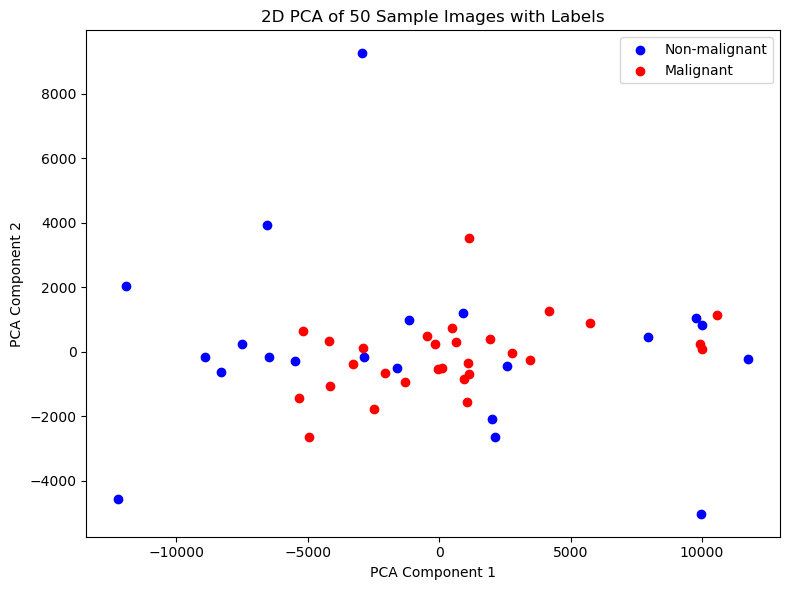

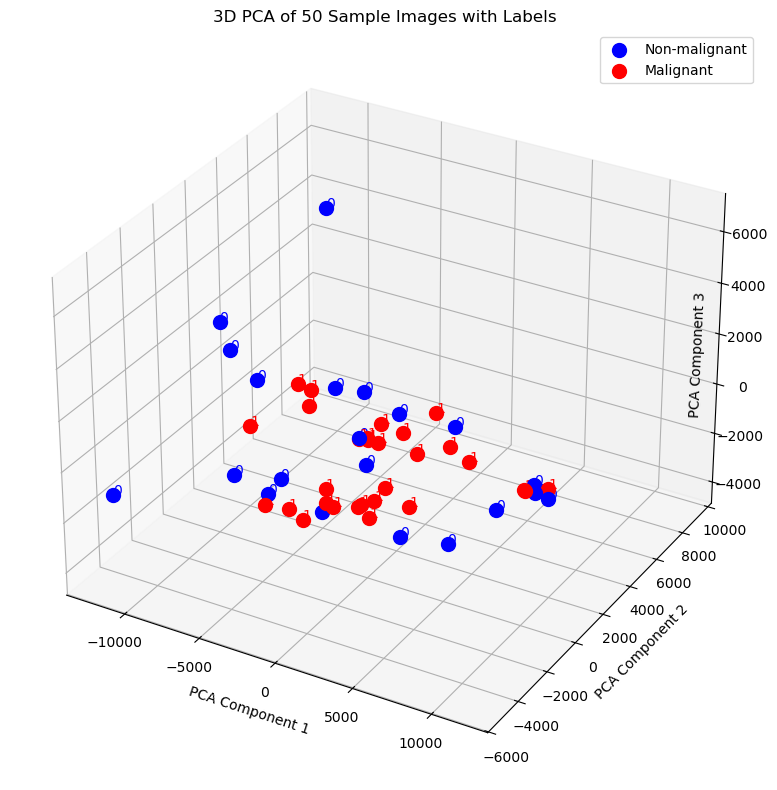

In [68]:
sample = 50
x_train_subset = x_train[:sample]
y_train_subset = y_train[y_train.columns[0]][:sample]
x_train_flat = x_train_subset.reshape(sample, -1)

#Apply PCA to reduce dimensions to 2 dimesions
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_flat)

#Plot the 2D PCA result with colors based on labels
plt.figure(figsize=(8, 6))
for i, label in enumerate(y_train_subset):
    color = 'blue' if label == 0 else 'red'
    plt.scatter(x_train_pca[i, 0], x_train_pca[i, 1], color=color, label=f"Label {label}" if i == 0 else "")

#Add labels, title, and legend
plt.title(f'2D PCA of {sample} Sample Images with Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(['Non-malignant', 'Malignant'], loc='upper right')
plt.tight_layout()
plt.show()

# Apply 3D PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train_flat)

#Plot the 3D PCA result with colors based on labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(y_train_subset):
    color = 'blue' if label == 0 else 'red'
    ax.scatter(x_train_pca[i, 0], x_train_pca[i, 1], x_train_pca[i, 2], color=color, s=100)
    ax.text(x_train_pca[i, 0] + 0.1, x_train_pca[i, 1] + 0.1, x_train_pca[i, 2] + 0.1, str(label), color=color)

# Add labels, title, and legend
ax.set_title(f'3D PCA of {sample} Sample Images with Labels')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3', labelpad=-30)
plt.legend(['Non-malignant', 'Malignant'], loc='upper right')
plt.tight_layout()
plt.show()

### Interpretation of 2D and 3D PCA of PCAM Images

#### Observations from 2D PCA
- **Cluster Overlap**: The red (malignant) and blue (non-malignant) points show some overlap, indicating that the first two principal components do not completely separate the two classes. This suggests that malignancy may not be entirely distinguishable based solely on these two components.
- **Variance**: The spread of data across the two components shows that the images vary along these axes, but the lack of clear class division implies that additional components or features may be required for better discrimination.

#### Observations from 3D PCA
- **Increased Separation in 3D Space**: Adding a third component provides more depth, leading to slight improvements in class separability. However, significant overlap remains between the red and blue points, indicating that the classes aren't fully separable even in 3D space.
- **Feature Complexity**: The overlap suggests that distinguishing malignant from non-malignant cases likely requires complex, multi-dimensional features. PCA, a linear transformation, may not capture all the intricate patterns that could aid in separation.

#### Insights for Model Development
- **High-Dimensional Feature Space**: The overlap in PCA plots indicates that separating malignant and non-malignant images requires a high-dimensional feature space, where nonlinear relationships are better captured by models like CNNs.
- **Need for Deep Learning**: CNNs are suitable for identifying subtle patterns across multiple layers, potentially extracting features that PCA cannot capture. The PCA analysis underscores that raw pixel values (or their linear combinations) alone are insufficient for clear class separation, highlighting the necessity of CNN's hierarchical and nonlinear feature extraction.

In summary, while PCA provides a glimpse into the data structure, the overlap in these PCA plots reinforces the importance of using a CNN model for more effective feature extraction and classification in the PCAM dataset.

## TSNE  
Applying t-SNE (t-Distributed Stochastic Neighbor Embedding) for visualizing high-dimensional image data in a lower-dimensional space, in 2D and 3D. t-SNE is particularly good at preserving local structure, making it useful for identifying clusters or patterns in image data.

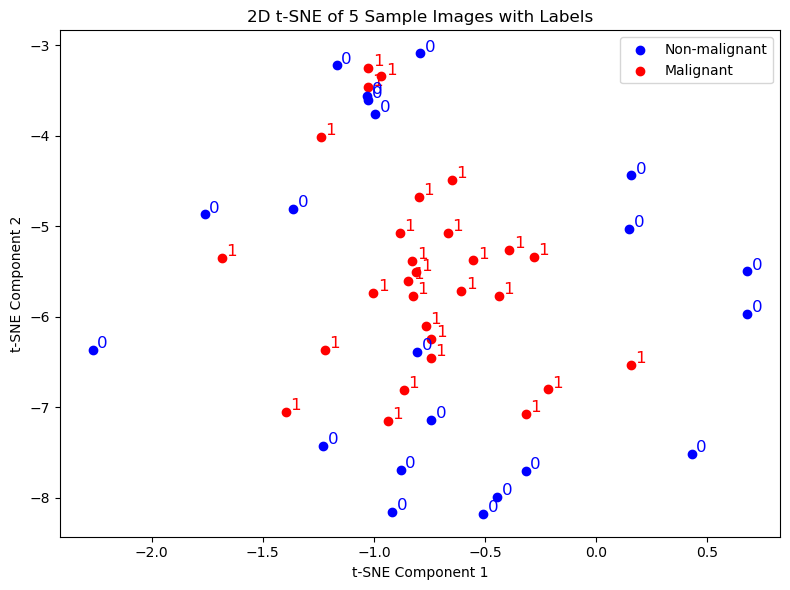

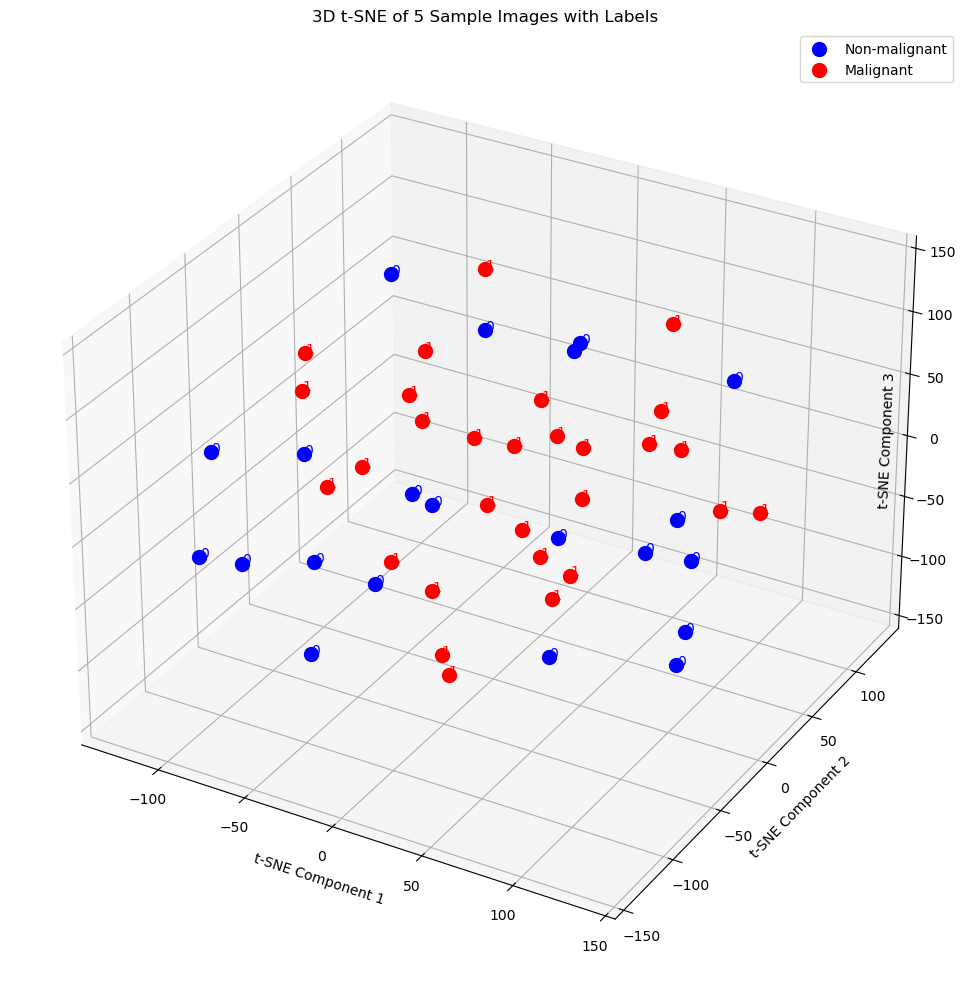

In [69]:
tsne_2d = TSNE(n_components=2, random_state=42)
x_train_tsne_2d = tsne_2d.fit_transform(x_train_flat)

#Plot the 2D t-SNE result with colors based on labels
plt.figure(figsize=(8, 6))
for i, label in enumerate(y_train_subset):
    color = 'blue' if label == 0 else 'red'
    plt.scatter(x_train_tsne_2d[i, 0], x_train_tsne_2d[i, 1], color=color, label=f"Label {label}" if i == 0 else "")
    plt.text(x_train_tsne_2d[i, 0] + 0.02, x_train_tsne_2d[i, 1] + 0.02, str(label), fontsize=12, color=color)

# Add labels, title, and legend
plt.title('2D t-SNE of 50 Sample Images with Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(['Non-malignant', 'Malignant'], loc='upper right')
plt.tight_layout()
plt.show()

tsne_3d = TSNE(n_components=3, random_state=42)
x_train_tsne_3d = tsne_3d.fit_transform(x_train_flat)

# Plot the 3D t-SNE result with colors based on labels
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(y_train_subset):
    color = 'blue' if label == 0 else 'red'
    ax.scatter(x_train_tsne_3d[i, 0], x_train_tsne_3d[i, 1], x_train_tsne_3d[i, 2], color=color, s=100)
    ax.text(x_train_tsne_3d[i, 0] + 0.1, x_train_tsne_3d[i, 1] + 0.1, x_train_tsne_3d[i, 2] + 0.1, str(label), color=color)

# Add labels, title, and legend
ax.set_title('3D t-SNE of 50 Sample Images with Labels')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3', labelpad=-30)
plt.legend(['Non-malignant', 'Malignant'], loc='upper right')
plt.tight_layout()
plt.show()

### Interpretaion of 2D and 3D t-SNE

- t-SNE remains consistent with the observations from PCA. It emphasizes on a need for a complex learning model due to lack separability in any form. A CNN model will be more effective for feature extraction and classification in the PCAM dataset.

The following class is defined to perform transformations on the datasets. These transformations include Data Augmentation by random horizontal flips and normalizing images.

In [5]:
class PCamDataset(Dataset):
    def __init__(self, images, labels, transform_train = None, transform_val = None, transform_test = None):
        self.images = images if isinstance(images, np.ndarray) else np.array(images)
        self.labels = labels.values if isinstance(labels, pd.DataFrame) else np.array(labels)
        
        # Transformations to be applied to the images
        self.transform_train = transform_train
        self.transform_val = transform_val
        self.transform_test = transform_test

    def __len__(self):
        return len(self.images) 
    
    def __getitem__(self, idx):

        image = self.images[idx]
        label = self.labels[idx]

        if self.transform_train:
            image = self.transform_train(image)
        if self.transform_val:
            image = self.transform_val(image)
        if self.transform_test:
            image = self.transform_test(image)

        return image, label

Computing mean and standard deviation for each dataset separated for each channel

In [6]:
def compute_mean_std(dataset):
    # Compute mean and std along the height, width, and sample axes
    mean_values = np.mean(dataset, axis=(0, 1, 2)) / 255
    std_values = np.std(dataset, axis=(0, 1, 2)) / 255
    return mean_values, std_values

mean_values_train, std_values_train = compute_mean_std(x_train)
mean_values_val, std_values_val = compute_mean_std(x_val)
mean_values_test, std_values_test = compute_mean_std(x_test)

# Split mean values and std values into separate components for RGB channels
mean_value_R_train, mean_value_G_train, mean_value_B_train = mean_values_train
std_value_R_train, std_value_G_train, std_value_B_train = std_values_train

mean_value_R_val, mean_value_G_val, mean_value_B_val = mean_values_val
std_value_R_val, std_value_G_val, std_value_B_val = std_values_val

mean_value_R_test, mean_value_G_test, mean_value_B_test = mean_values_test
std_value_R_test, std_value_G_test, std_value_B_test = std_values_test

# Display results for verification
print("Train mean values:", mean_values_train)
print("Train std values:", std_values_train)
print("Validation mean values:", mean_values_val)
print("Validation std values:", std_values_val)
print("Test mean values:", mean_values_test)
print("Test std values:", std_values_test)

Train mean values: [0.70105999 0.53995758 0.69499052]
Train std values: [0.2346119  0.27637937 0.21190233]
Validation mean values: [0.70243598 0.53704146 0.69387274]
Validation std values: [0.23160563 0.27399555 0.21017143]
Test mean values: [0.68060977 0.52425956 0.69440137]
Test std values: [0.24115132 0.28238104 0.2101764 ]


In [7]:
# Define the transformations to be applied to the images
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[mean_value_R_train, mean_value_G_train, mean_value_B_train], std=[std_value_R_train, std_value_G_train, std_value_B_train])
])

transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[mean_value_R_val, mean_value_G_val, mean_value_B_val], std=[std_value_R_val, std_value_G_val, std_value_B_val])
])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[mean_value_R_test, mean_value_G_test, mean_value_B_test], std=[std_value_R_test, std_value_G_test, std_value_B_test])
])

# Model Selection  
### Traditional ML models
We will first try to use traditional models:
1. Random Forest
2. SVM
3. K-neighbours

In [ ]:
# Create random subsets
x_trainCA, _, y_trainCA, _ = train_test_split(x_train, y_train, train_size=10000, stratify=y_train, random_state=42)
x_valCA, _, y_valCA, _ = train_test_split(x_val, y_val, train_size= 2500, stratify=y_val, random_state=42)
x_testCA, _, y_testCA, _ = train_test_split(x_test, y_test, train_size= 2500, stratify=y_test, random_state=42)


# Print the sizes of the subsets
print(f"Subset size - TRAIN : {len(y_trainCA)}")
print(f"Subset size - VAL : {len(y_valCA)}")
print(f"Subset size - TEST : {len(y_testCA)}")


# Print the target variables for checking if the balance is mantained
print(f"\nTarget variable balance - TRAIN: {y_trainCA.value_counts()}")
print(f"\nTarget variable balance - VAL: {y_valCA.value_counts()}")
print(f"\nTarget variable balance - TEST: {y_testCA.value_counts()}")

#Normalization
x_trainCA = (x_trainCA/255.0)
x_valCA = (x_valCA/255.0)
x_testCA = (x_testCA/255.0)

# Reshaping
nsamples, nx, ny, nrgb = x_trainCA.shape
x_trainCA = x_trainCA.reshape((nsamples,nx*ny*nrgb))


nsamples, nx, ny, nrgb = x_valCA.shape
x_valCA = x_valCA.reshape((nsamples,nx*ny*nrgb))


nsamples, nx, ny, nrgb = x_testCA.shape
x_testCA = x_testCA.reshape((nsamples,nx*ny*nrgb))

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(x_trainCA, y_trainCA.values.ravel())
y_pred_rf = rf_model.predict(x_valCA)


# SVM
svm_model = SVC()
svm_model.fit(x_trainCA, y_trainCA.values.ravel())
y_pred_svm = svm_model.predict(x_valCA)


# K-neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(x_trainCA, y_trainCA.values.ravel())
y_pred_knn = knn_model.predict(x_valCA)


#XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_trainCA, y_trainCA.values.ravel())
y_pred_xgb = xgb_model.predict(x_valCA)



# Function to evaluate metrics
def evaluate_metrics(y_pred,y_true):
   acc = accuracy_score(y_pred,y_true)
   precision = precision_score(y_true, y_pred, average='weighted')
   recall = recall_score(y_true, y_pred, average='weighted')
   f1 = f1_score(y_true, y_pred, average='weighted')
   return acc, precision, recall, f1

# Metrics computation
acc_rf, precision_rf, recall_rf, f1_rf = evaluate_metrics(y_pred_rf, y_valCA)
acc_svm, precision_svm, recall_svm, f1_svm = evaluate_metrics(y_pred_svm, y_valCA)
acc_knn, precision_knn, recall_knn, f1_knn = evaluate_metrics(y_pred_knn, y_valCA)
acc_xgb, precision_xgb, recall_xgb, f1_xgb = evaluate_metrics(y_pred_xgb, y_valCA)


# Metrics evaluation on validation set
metrics_data = {
   'Model': ['Random Forest', 'SVM', 'K-Neighbors', 'XGBoost'],
   'Accuracy': [acc_rf, acc_svm, acc_knn, acc_xgb],
   'Precision': [precision_rf, precision_svm, precision_knn, precision_xgb],
   'Recall': [ recall_rf, recall_svm, recall_knn,recall_xgb ],
   'F1 Score': [f1_rf, f1_svm, f1_knn,f1_xgb ]
}


metrics_val_df = pd.DataFrame(metrics_data).round(3)
metrics_val_df


## Convultional Neural Network

In [8]:
# Create the dataset objects
train_dataset = PCamDataset(images= x_train, labels= y_train, transform_train = transform_train)
valid_dataset = PCamDataset(images= x_val,   labels= y_val,   transform_val= transform_val )
test_dataset = PCamDataset(images= x_test,   labels= y_test,   transform_test = transform_test )
#Define batch size and create the data loaders
## NOTE: Make sure num_workers=0 to avoid issues with multiprocessing
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False,  num_workers=0)

The following class defines the model architecture, loss function and learning algorithm

In [9]:
class PCamClassification(nn.Module):
    def __init__(self):
        super(PCamClassification, self).__init__()
        #Seven Convolutional Layers with Batch Normalization and Max Pooling
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.dropout = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(256, 1)
        
        # Metrics to store for validation and testing
        self.train_acc = torchmetrics.classification.BinaryAccuracy(threshold=0.5, multidim_average='global')
        self.valid_acc = torchmetrics.classification.BinaryAccuracy(threshold=0.5, multidim_average='global')

        # Lists to store the losses and accuracies
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
        self.test_losses = []
        self.test_accs = []
        self.avg_train_losses = []
        self.avg_train_accs = []
        self.avg_val_losses = []
        self.avg_val_accs = []
        

    # Define the forward pass
    def forward(self, x):
        # Adding a pooling layer after each block
        x = F.relu(self.bn1(self.conv1(x))) 
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool(x)

        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  
        return x
    
    # Define the Training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) # Predictions
        loss = F.binary_cross_entropy_with_logits(y_pred, y.float()) # Loss Function
        acc = self.train_acc(y_pred, y)
        self.train_accs.append(acc.item())
        self.train_losses.append(loss.item())
        return loss
    
    # Define the Validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.binary_cross_entropy_with_logits(y_pred, y.float())
        acc = self.valid_acc(y_pred, y)
        
        # Add the outputs to the lists
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())
        
        return loss
    
    # Log the losses and accuracies at the end of each epoch or train
    def on_train_epoch_end(self):
        avg_train_loss = np.mean(self.train_losses)
        avg_train_acc = np.mean(self.train_accuracy)
        self.log('train_loss', avg_train_loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', avg_train_acc, on_epoch=True, prog_bar=True)
        self.avg_train_losses.append(avg_train_loss)
        self.avg_train_accuracy.append(avg_train_acc)
        self.train_losses.clear()
        self.train_accuracy.clear()

    # Log the losses and accuracies at the end of each epoch of validation
    def on_validation_epoch_end(self):
        avg_val_loss = np.mean(self.val_losses)
        avg_val_acc = np.mean(self.val_accuracy)
        self.log('val_loss', avg_val_loss, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('val_acc', avg_val_acc, on_epoch=True, prog_bar=True, sync_dist=True)
        self.avg_val_losses.append(avg_val_loss)
        self.avg_val_accuracy.append(avg_val_acc)
        self.val_losses.clear()
        self.val_accuracy.clear()
    
   # Calculate probabilites and predictions for each batch
    def predict(self, dataloader):
        # Set model to eval mode
        self.eval()
        y_pred = []
        y_true = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader):
                x, y = batch
                y_true.extend(y.detach().cpu().numpy().tolist())
                output = self.forward(x)
                probabilities = torch.sigmoid(output)
                # Convert the probabilities to binary predictions
                predictions = (probabilities >= 0.5).long()
                # Converts the tensor from gpu to cpu and then to a list
                y_pred.extend(predictions.view(-1).detach().cpu().numpy().tolist())
        # Set the model to the training mode again
        self.train()
        return np.array(y_pred)

    # Define the Adam Optimizer 
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=1e-5)

In [10]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   patience= 3,
   verbose=False,
   mode='min'
)

# Save as a checkpoint after each epoch
checkpoint_callback = ModelCheckpoint(
     monitor='val_loss', # Monitor the validation loss
     dirpath='checkpoints',
     filename='Model1-Variant-{epoch}-{val_loss:.2f}',
     save_top_k= -1  
 )

csv_logger = CSVLogger('logs', name='baseline-{np.random.randint(1000)}') #Store the logs in a csv file
trainer = pl.Trainer(
        min_epochs= 10,
        max_epochs=20,
        devices=1,
        accelerator='mps', # Configure this to CPU or GPU if you face any error
        deterministic=True, # Ensure reproducibility and randomness
        logger=csv_logger,
        callbacks=[early_stop_callback, checkpoint_callback]
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Warning: DO NOT RUN OR EDIT THE BELOW CELLS  
Following cells trains the model and may consume a lot of time and resources

In [18]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # Permute to [batch_size, channels, height, width]
y_train_tensor = torch.tensor(y_train.squeeze().to_numpy(), dtype=torch.float32)

In [14]:
# model = PCamClassification()
# print(model)
# trainer.fit(model, train_loader, valid_loader)

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

net = NeuralNetBinaryClassifier(
    PCamClassification,
    max_epochs=10,
    lr=0.01,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    train_split=None,  # Use the provided train/validation split
    device=device
)

params = {
    'lr': uniform(0.005, 0.1),
    'optimizer__weight_decay': uniform(1e-5, 1e-3)
}

gs = RandomizedSearchCV(
    net,
    param_distributions=params,
    n_iter=10,              # Number of parameter settings to sample
    refit=True,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42         # Ensure reproducibility
)


gs.fit(x_train_tensor, y_train_tensor)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
  epoch    train_loss      dur
-------  ------------  -------
      1        3.1395  21.3208
      2        0.4413  19.6205
      3        0.4423  19.6675
      4        0.4229  19.6607
      5        0.4078  19.4346
      6        0.4056  19.7996
      7        0.3859  19.3451
      8        0.3854  19.0462
      9        0.3858  19.7811
     10        0.3781  19.3689
[CV] END lr=0.04245401188473625, optimizer__weight_decay=0.0009607143064099162; total time= 3.4min
  epoch    train_loss      dur
-------  ------------  -------
      1        3.0642  20.1502
      2        0.4586  19.4005
      3        0.4226  19.2990
      4        0.4198  19.0788
      5        0.4050  20.3393
      6        0.4040  20.3697
      7        0.3968  18.7565
      8        0.3912  19.2643
      9        0.3919  19.0436
     10        0.3941  18.6934
[CV] END lr=0.04245401188473625, optimizer__weight_decay=0.0009607143064099162; total time= 3.4m

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.classifier.NeuralNetBinaryClassifier'>[uninitialized](
  module=<class '__main__.PCamClassification'>,
),
                   param_distributions={'lr': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x179482f20>,
                                        'optimizer__weight_decay': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x179481510>},
                   random_state=42, scoring='accuracy', verbose=2)

In [19]:
print("Best Parameters:", gs.best_params_)

Best Parameters: {'lr': 0.010808361216819946, 'optimizer__weight_decay': 0.0008761761457749352}


In [16]:
# model = PCamClassification()
# print(model)
# trainer.fit(model, train_loader, valid_loader)

In [108]:
# Retrieve the best model from the checkpoints folder
best_model_path = checkpoint_callback.best_model_path
best_model = PCamClassification.load_from_checkpoint(best_model_path)
print(best_model_path)
# Save the best model
filename = os.path.basename(best_model_path)
filename_without_extension = os.path.splitext(filename)[0]
torch.save(model, f'Best_Model/{filename_without_extension}.pth')

'/Users/praneetsurabhi/Desktop/PCAM/checkpoints/PatchCamelyon-epoch=07-val_loss=0.39.ckpt'

# Testing  
1. Please fill the variable *filename_without_extension* to import the model  
2. You can also create a custom test_loader but make sure num_workers=0  

In [119]:
filename_without_extension = 'Model1-Variant1' #Insert the filename without extension
best_model = torch.load(f'Best_Model/{filename_without_extension}.pth')

/var/folders/vd/335h5jcj7cg0s8l8_29j80dm0000gn/T/ipykernel_93654/2413677817.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f'Best_Model/{filenam

In [78]:
# batch_size = 64
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False, num_workers=0)
best_model = best_model.cpu()
y_pred = best_model.predict(test_loader)

100%|██████████| 79/79 [00:09<00:00,  8.64it/s]


### Model Evaluation  
Evaluate the model on various metrics like:  
1. accuracy
2. Precision
3. Recall
4. F1_score

In [82]:
accuracy = round(accuracy_score(y_test, y_pred) * 100, 3)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2 * (precision * recall) / (precision + recall)
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a dataframe
data = {'Metric': ['Accuracy', 'Precision', 'Recall', 'f1_score'], 'Value': [accuracy, precision, recall, f1_score]}
metrics = pd.DataFrame(data)

In [83]:
print(metrics)

      Metric      Value
0   Accuracy  87.560000
1  Precision   0.867084
2     Recall   0.887200
3   f1_score   0.877026


In [92]:
def plot_validation_accuracy(avg_val_accuracy):
    epochs = np.arange(len(avg_val_accuracy))
    plt.plot(epochs, avg_val_accuracy, color='#2b8cbe', marker='o', markersize=5, linestyle='-', linewidth=2, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy per Epoch')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_combined_losses(avg_train_losses, avg_val_losses):
    epochs1 = np.arange(len(avg_train_losses))
    epochs2 = np.arange(len(avg_val_losses))
    plt.plot(epochs1, avg_train_losses, color='#2b8cbe', marker='o', markersize=5, linestyle='-', linewidth=2, label='Training Loss')
    plt.plot(epochs2, avg_val_losses, color='#fc5c5c', marker='o', markersize=5, linestyle='-', linewidth=2, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, conf_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm_r', cbar=False, annot_kws={'size': 14}, 
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


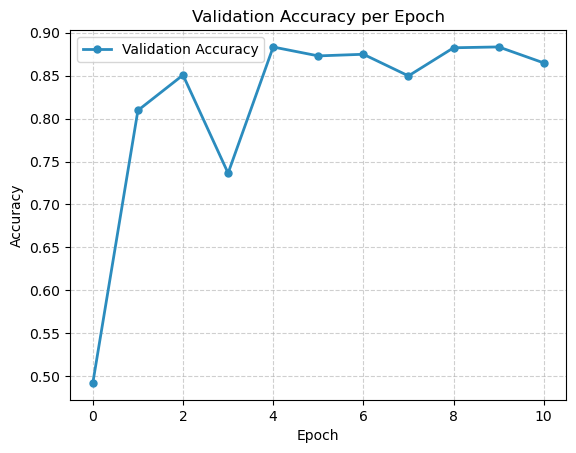

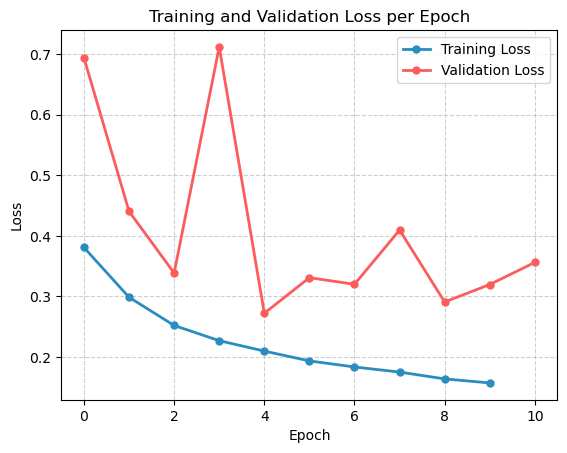

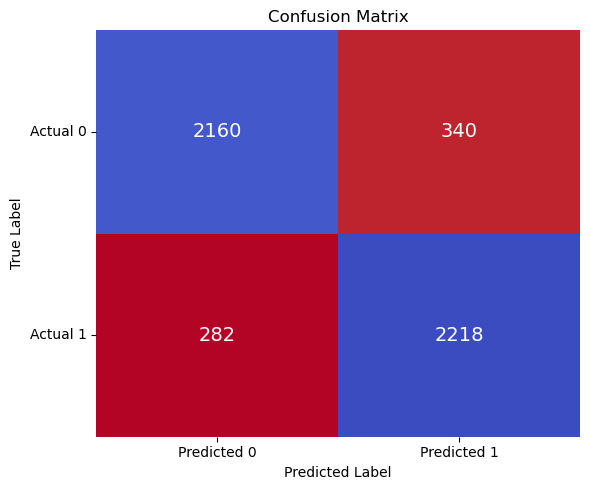

In [93]:
plot_validation_accuracy(best_model.avg_val_accs)
plot_combined_losses(best_model.avg_train_losses, best_model.avg_val_losses)
plot_confusion_matrix(y_test, y_pred, conf_matrix)